# Import all necessary libraries

In [1]:
import spacy
import pandas as pd
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

# Preprocessing

In [2]:
# Load en_core_web_lg model
nlp = spacy.load('en_core_web_lg', exclude=['parser', 'ner', 'textcat'])

def preprocess(text):
    """Preprocess the given text by tokenising it, removing any stop words, 
    replacing each remaining token with its lemma (base form), and discarding 
    all lemmas that contain non-alphabetical characters.

    Arguments:
      text (str): The text to preprocess.

    Returns:
      The list of remaining lemmas after preprocessing (represented as strings).
    """
    #Create a list to store the final text
    final_text = []
    #Tokenize it
    doc = nlp(text)
    #For each token
    for token in doc:
      #Check if it is a stop word
        if token.is_stop == True :
            continue
        else:
          #Check if it contains alphabetical characters
          if token.is_alpha==True:
            #Store the lemma
            final_text.append(token.lemma_)
    return final_text


# Evaluation of the predictions

In [3]:
def evaluation_scores_multi_class_classificaiton(actual, pred):
    """Creates confusion matrix for each class and prints precision, recall, and F1 score.
    
    Arguments:
        actual: The list with the actual values.
        pred: The list with the predicted values.
    """
    #Classes
    classes = ['positive', 'negative', 'neutral']
    #Create a confusion matrix for all the classes
    confusion_matrix = multilabel_confusion_matrix(actual, pred, labels=classes)
    #Switch TP with TN --> Easier for me to ensure that I have the correct values
    for i in range(3):
        confusion_matrix[i][0][0], confusion_matrix[i][1][1] = confusion_matrix[i][1][1], confusion_matrix[i][0][0]

    #For each confusion matrix fix the labels and get the name of the confusion matrix
    for i in range(3):
        print(f"Confusion matrix for class {classes[i]}:")
        #Creates pandas dataframe from confusion matrix for true positive, false negative, false positive, true negative
        print(pd.DataFrame(confusion_matrix[i], columns=['Positive(Actual)', 'Negative(Actual)'], index=['Positive(Pred)','Negative(Pred)']))
        #Index is Prediction and columns is actual
    #Get the measurements of the error
    print(classification_report(actual, pred))

# Load all datasets

In [58]:
def all_datasets_run():
    """Read in all datasets and return them as a list with pandas dataframes.
    
    Returns:
        dictionary: Dictionary with key as name of the file and value as the dataset as pandas dataframe
    """
    #Load in the data from huggingfaces
    dataset = load_dataset("FinanceInc/auditor_sentiment")    
    #convert dataset to pandas dataframe
    dataset_training = dataset["train"].to_pandas()
    dataset_validation = dataset["test"].to_pandas()
    #Combine both datasets
    df1 = pd.concat([dataset_training, dataset_validation], ignore_index=True)
    #Change name of the columns
    df1.columns = ['Sentence', 'Sentiment']
    #Change name from numeric to corresponding sentiment
    df1['Sentiment'] = df1['Sentiment'].replace(2, 'positive')
    df1['Sentiment'] = df1['Sentiment'].replace(1, 'neutral')
    df1['Sentiment'] = df1['Sentiment'].replace(0, 'negative')

    #Read json file as pandas dataframe
    df = pd.read_json('data/Fin-SoMe Data.json')
    #Create new dataframe with sentiment and tweet column
    df2 = df[['tweet', 'sentiment']].copy()
    #If sentiment is unsure set it to neutral
    df2['sentiment'] = df2['sentiment'].replace('Unsure', 'neutral')
    #Set sentiment to lowercase
    df2['sentiment'] = df2['sentiment'].str.lower()
    #Set all values in sentiment column 2, 4, 5,6 columns
    df2.columns = ['Sentence', 'Sentiment']
    

    df3 = pd.read_csv("data/SEntFiN-v1.1.csv")
    #Get 3rd and 4th column
    df3 = df3.iloc[:, 1:3]
    df3.columns = ['Sentence', 'Sentiment']
    #Store only rows that has one value in the Sentiment column - Remove rows that have multiple values by ","
    df3 = df3[df3['Sentiment'].str.contains(", ") == False]

    #Get the sentiment from the dictionary, as it is a dictionary, we need to split it and get the second value
    #Thereafter, we need to remove the "}" and '"' from the string
    df3['Sentiment'] = df3['Sentiment'].apply(lambda x: x.split(":")[1].strip("}").replace('"', ''))

    #Drop all " " in the Sentiment column
    df3['Sentiment'] = df3['Sentiment'].str.replace(" ", "").str.lower()

    #Return dictionary with name of the dataset as key and the dataset as value
    return {"SEntFiN-v1.1":df3, "Fin-SoMe Data":df2, "Financial Phrasebank": df1}

# Run different methods on datasets

In [61]:
def run_models_on_dataset(datasets: dict):
    """Create all models and return the results.
    
    Arguments:
        datasets: Dictionary with name of the dataset as key and pandas dataframe as value
    """

    #Finbert EXPLAIN MORE!!!
    tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
    model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")
    classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
    
    #Read Json file
    lexicon_ntusd = pd.read_json('data/NTUSD-Fin/NTUSD_Fin_word_v1.0.json')
    #Store only token and sentiment
    lexicon_ntusd = lexicon_ntusd[['token', 'market_sentiment']].copy()
    #Create dictionary from dataframe
    lexicon_ntusd_dict = lexicon_ntusd.set_index('token').to_dict()

    #Create object for Vader
    analyzer = SentimentIntensityAnalyzer()
    
    #For each dataset in the datasets
    for keys, dataset in datasets.items():
        #Print the name of the data set
        print(f"For dataset: " + keys)
        #Split df into training and validation sets with x and y
        X = dataset['Sentence']
        Y = dataset['Sentiment']

        #Split into training and validation sets
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1337)

        #Vectorize the data with TF-IDF
        vectorizer = TfidfVectorizer(tokenizer=preprocess).fit(X_train)
        X_transformed_train = vectorizer.transform(X_train)
        X_transformed_test = vectorizer.transform(X_test)
        #First userwarning is due to tokenizer = preprocess --> Seems not to be a problem

        #Create an objectiv from SVM
        clf_trained = svm.SVC()
        #Fit it to the training data
        clf_trained.fit(X_transformed_train, Y_train)
        #Predict the test data
        svm_predict = clf_trained.predict(X_transformed_test)
        #Print the result, confusion matrix and the measurements
        print("Results for SVM:")
        evaluation_scores_multi_class_classificaiton(Y_test, svm_predict)


        #Classify all the sentences
        pred_bert = classifier(X.values.tolist())

        #For each value in pred_train get the label and store it in a list
        y_pred_bert_list = []
        for i in range(len(pred_bert)):
            y_pred_bert_list.append(pred_bert[i]['label'])
        #Print the result, confusion matrix and the measurements
        print("Result for FinBert:")
        evaluation_scores_multi_class_classificaiton(Y, y_pred_bert_list)

        #Lexicon - NTUSD_Fin
        #Preprocess the text and store it in the list
        preprocessed_text = []
        for text in X:
            preprocessed_text.append(preprocess(text))

        pred_lexicon = []
        #Set the threshold
        threshold  = 0.5
        #For each sentence in the text
        for sentence in preprocessed_text:
            score = 0
            #Get the score of each word
            for word in sentence:
                try:
                    score += lexicon_ntusd_dict['market_sentiment'][word]
                except:
                    continue
            #Make the prediction of the sentiment of the sentence, depending on the score.
            if score > threshold:
                pred_lexicon.append('positive')
            elif score < -threshold:
                pred_lexicon.append('negative')
            else:
                pred_lexicon.append('neutral')
        #Print the result, confusion matrix and the measurements
        print("Result for Lexicon NTUSD-Fin:")
        evaluation_scores_multi_class_classificaiton(Y, pred_lexicon)

        #Lexicon - Vader
        pred_vader = []
        #Set the threshold
        threshold = 0.1
        #For each sentence, get the polarity
        for sentence in X:
            vs = analyzer.polarity_scores(sentence)
            #Get the compounded score of the sentence
            score = vs["compound"]
            #Predict the sentiment of the sentence depending on the threshold
            if score > threshold:
                pred_vader.append('positive')
            elif score < -threshold:
                pred_vader.append('negative')
            else:
                pred_vader.append('neutral')
        #Print the result, confusion matrix and the measurements
        print("Result for Lexicon Vader:")
        evaluation_scores_multi_class_classificaiton(Y, pred_vader)

In [62]:
#Run the dataset funcion
data_sets = all_datasets_run()
#Run the models on the dataset
run_models_on_dataset(data_sets)

For dataset: SEntFiN-v1.1


c:\Users\damia\anaconda3\envs\environment\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for SVM:
Confusion matrix for class positive:
                Positive(Actual)  Negative(Actual)
Positive(Pred)               494               144
Negative(Pred)               106               836
Confusion matrix for class negative:
                Positive(Actual)  Negative(Actual)
Positive(Pred)               340                74
Negative(Pred)               131              1035
Confusion matrix for class neutral:
                Positive(Actual)  Negative(Actual)
Positive(Pred)               399               129
Negative(Pred)               110               942
              precision    recall  f1-score   support

    negative       0.82      0.72      0.77       471
     neutral       0.76      0.78      0.77       509
    positive       0.77      0.82      0.80       600

    accuracy                           0.78      1580
   macro avg       0.78      0.78      0.78      1580
weighted avg       0.78      0.78      0.78      1580

Result for FinBert:
Confusion mat

c:\Users\damia\anaconda3\envs\environment\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for SVM:
Confusion matrix for class positive:
                Positive(Actual)  Negative(Actual)
Positive(Pred)              1479               469
Negative(Pred)                 2                27
Confusion matrix for class negative:
                Positive(Actual)  Negative(Actual)
Positive(Pred)                 1                 0
Negative(Pred)               139              1837
Confusion matrix for class neutral:
                Positive(Actual)  Negative(Actual)
Positive(Pred)                25                 3
Negative(Pred)               331              1618
              precision    recall  f1-score   support

    negative       1.00      0.01      0.01       140
     neutral       0.89      0.07      0.13       356
    positive       0.76      1.00      0.86      1481

    accuracy                           0.76      1977
   macro avg       0.88      0.36      0.34      1977
weighted avg       0.80      0.76      0.67      1977

Result for FinBert:
Confusion mat

c:\Users\damia\anaconda3\envs\environment\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for SVM:
Confusion matrix for class positive:
                Positive(Actual)  Negative(Actual)
Positive(Pred)               122                30
Negative(Pred)               169               649
Confusion matrix for class negative:
                Positive(Actual)  Negative(Actual)
Positive(Pred)                50                18
Negative(Pred)                55               847
Confusion matrix for class neutral:
                Positive(Actual)  Negative(Actual)
Positive(Pred)               554               196
Negative(Pred)                20               200
              precision    recall  f1-score   support

    negative       0.74      0.48      0.58       105
     neutral       0.74      0.97      0.84       574
    positive       0.80      0.42      0.55       291

    accuracy                           0.75       970
   macro avg       0.76      0.62      0.66       970
weighted avg       0.76      0.75      0.72       970

Result for FinBert:
Confusion mat

Text(0, 0.5, 'Number of sentences')

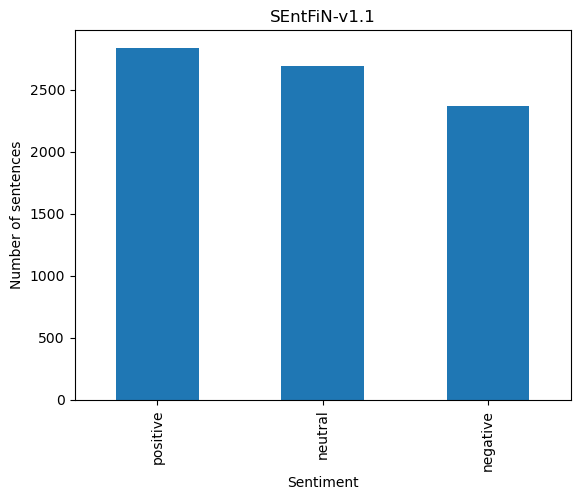

In [78]:
#{"SEntFiN-v1.1":df3, "Fin-SoMe Data":df2, "Financial Phrasebank": df1
#SEntFiN-v1.1
plt = data_sets["SEntFiN-v1.1"]["Sentiment"].value_counts().plot(kind="bar")
plt.set_title("SEntFiN-v1.1")
plt.set_ylabel("Number of sentences")

Text(0, 0.5, 'Number of sentences')

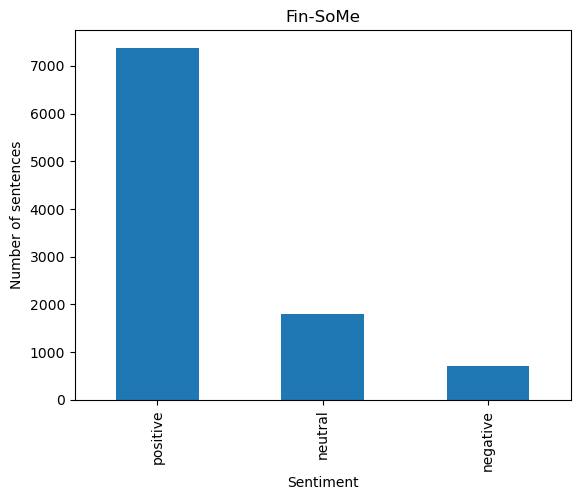

In [79]:
plt = data_sets["Fin-SoMe Data"]["Sentiment"].value_counts().plot(kind="bar")
plt.set_title("Fin-SoMe")
plt.set_ylabel("Number of sentences")

Text(0, 0.5, 'Number of sentences')

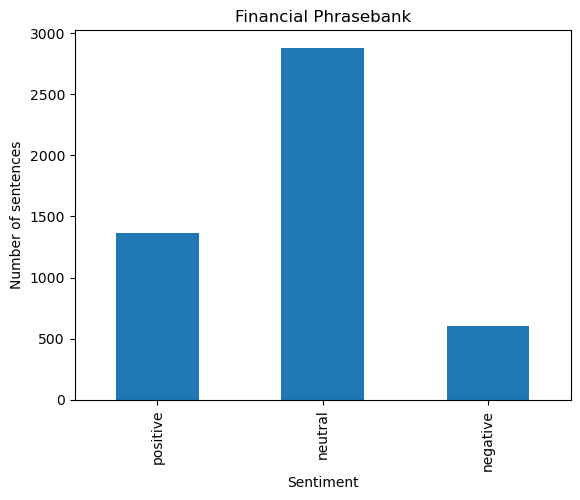

In [85]:
#Financial Phrasebank - This was changed in order to have the same classes in x-axis
#Count the number of each sentiment
counts = data_sets["Financial Phrasebank"]["Sentiment"].value_counts()

#Reorder the index
ordered_counts = counts.reindex(['positive', 'neutral', 'negative'])

#Barplot it
plt = ordered_counts.plot(kind="bar")

plt.set_title("Financial Phrasebank")
plt.set_ylabel("Number of sentences")